# **Delivery Time Prediction Project**

## **Project Overview**
This project aims to build a machine learning model to predict the delivery time of orders based on various features such as delivery person's age, weather conditions, traffic density, distance between the restaurant and delivery location, and other factors. The dataset contains order and delivery-related details, and the target variable is the time taken for the delivery in minutes.

## **Objectives**
- Preprocess the dataset by handling missing values, encoding categorical features, and feature engineering (e.g., extracting date features, calculating distances).
- Train multiple regression models including:
  - **Linear Regression**
  - **Decision Tree Regressor**
  - **Random Forest Regressor**
  - **XGBoost Regressor**
- Evaluate the models using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²).
- Perform hyperparameter tuning using **GridSearchCV** to optimize the performance of the **XGBoost model**.
- Save the best-tuned model for deployment.

---

##  Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
df_train = pd.read_csv('/home/hp/Downloads/train.csv')
df_train.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


## Dataset Overview

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

## Summary Statistics for numerical columns


In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


## Summary Statistics for non-numerical columns

In [5]:
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


## Data Cleaning

### 1.Format Column Names

In [6]:
#Change name Weatherconditions to Weather_conditions
df_train.rename(columns={'Weatherconditions': 'Weather_conditions'},inplace=True)
df_train.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


### 2.Data Extraction

In [7]:
def extract_column_value(df):
    #Extract time and convert to int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    #Extract Weather conditions
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    #Extract city code from Delivery person ID
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]

extract_column_value(df_train)
df_train[['Time_taken(min)','Weather_conditions','City_code']].head()
df_train['Time_taken(min)'] = df_train['Time_taken(min)'].astype('float64')

### 3.Update Data Types

In [8]:
#Update datatypes
def update_datatype(df):
    #Update datatype from object to float
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    #Update datatype from object to datetime
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")

update_datatype(df_train)

### 4.Check for Duplicate Values

In [9]:
#Check for Duplicate Values
if (len(df_train[df_train.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


### 5.Handle Missing Values

In [10]:
#Replace NaN to np.nan
df_train.replace('NaN', float(np.nan), regex=True,inplace=True)
#Show count of NaN values in data
df_train.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
ID                                0
Vehicle_condition                 0
Time_taken(min)                   0
Type_of_vehicle                   0
Type_of_order                     0
Time_Order_picked                 0
Delivery_person_ID                0
Order_Date                        0
Delivery_location_longitude       0
Delivery_location_latitude        0
Restaurant_longitude              0
Restaurant_latitude               0
City_code                         0
dtype: int64

## Data Visualisation

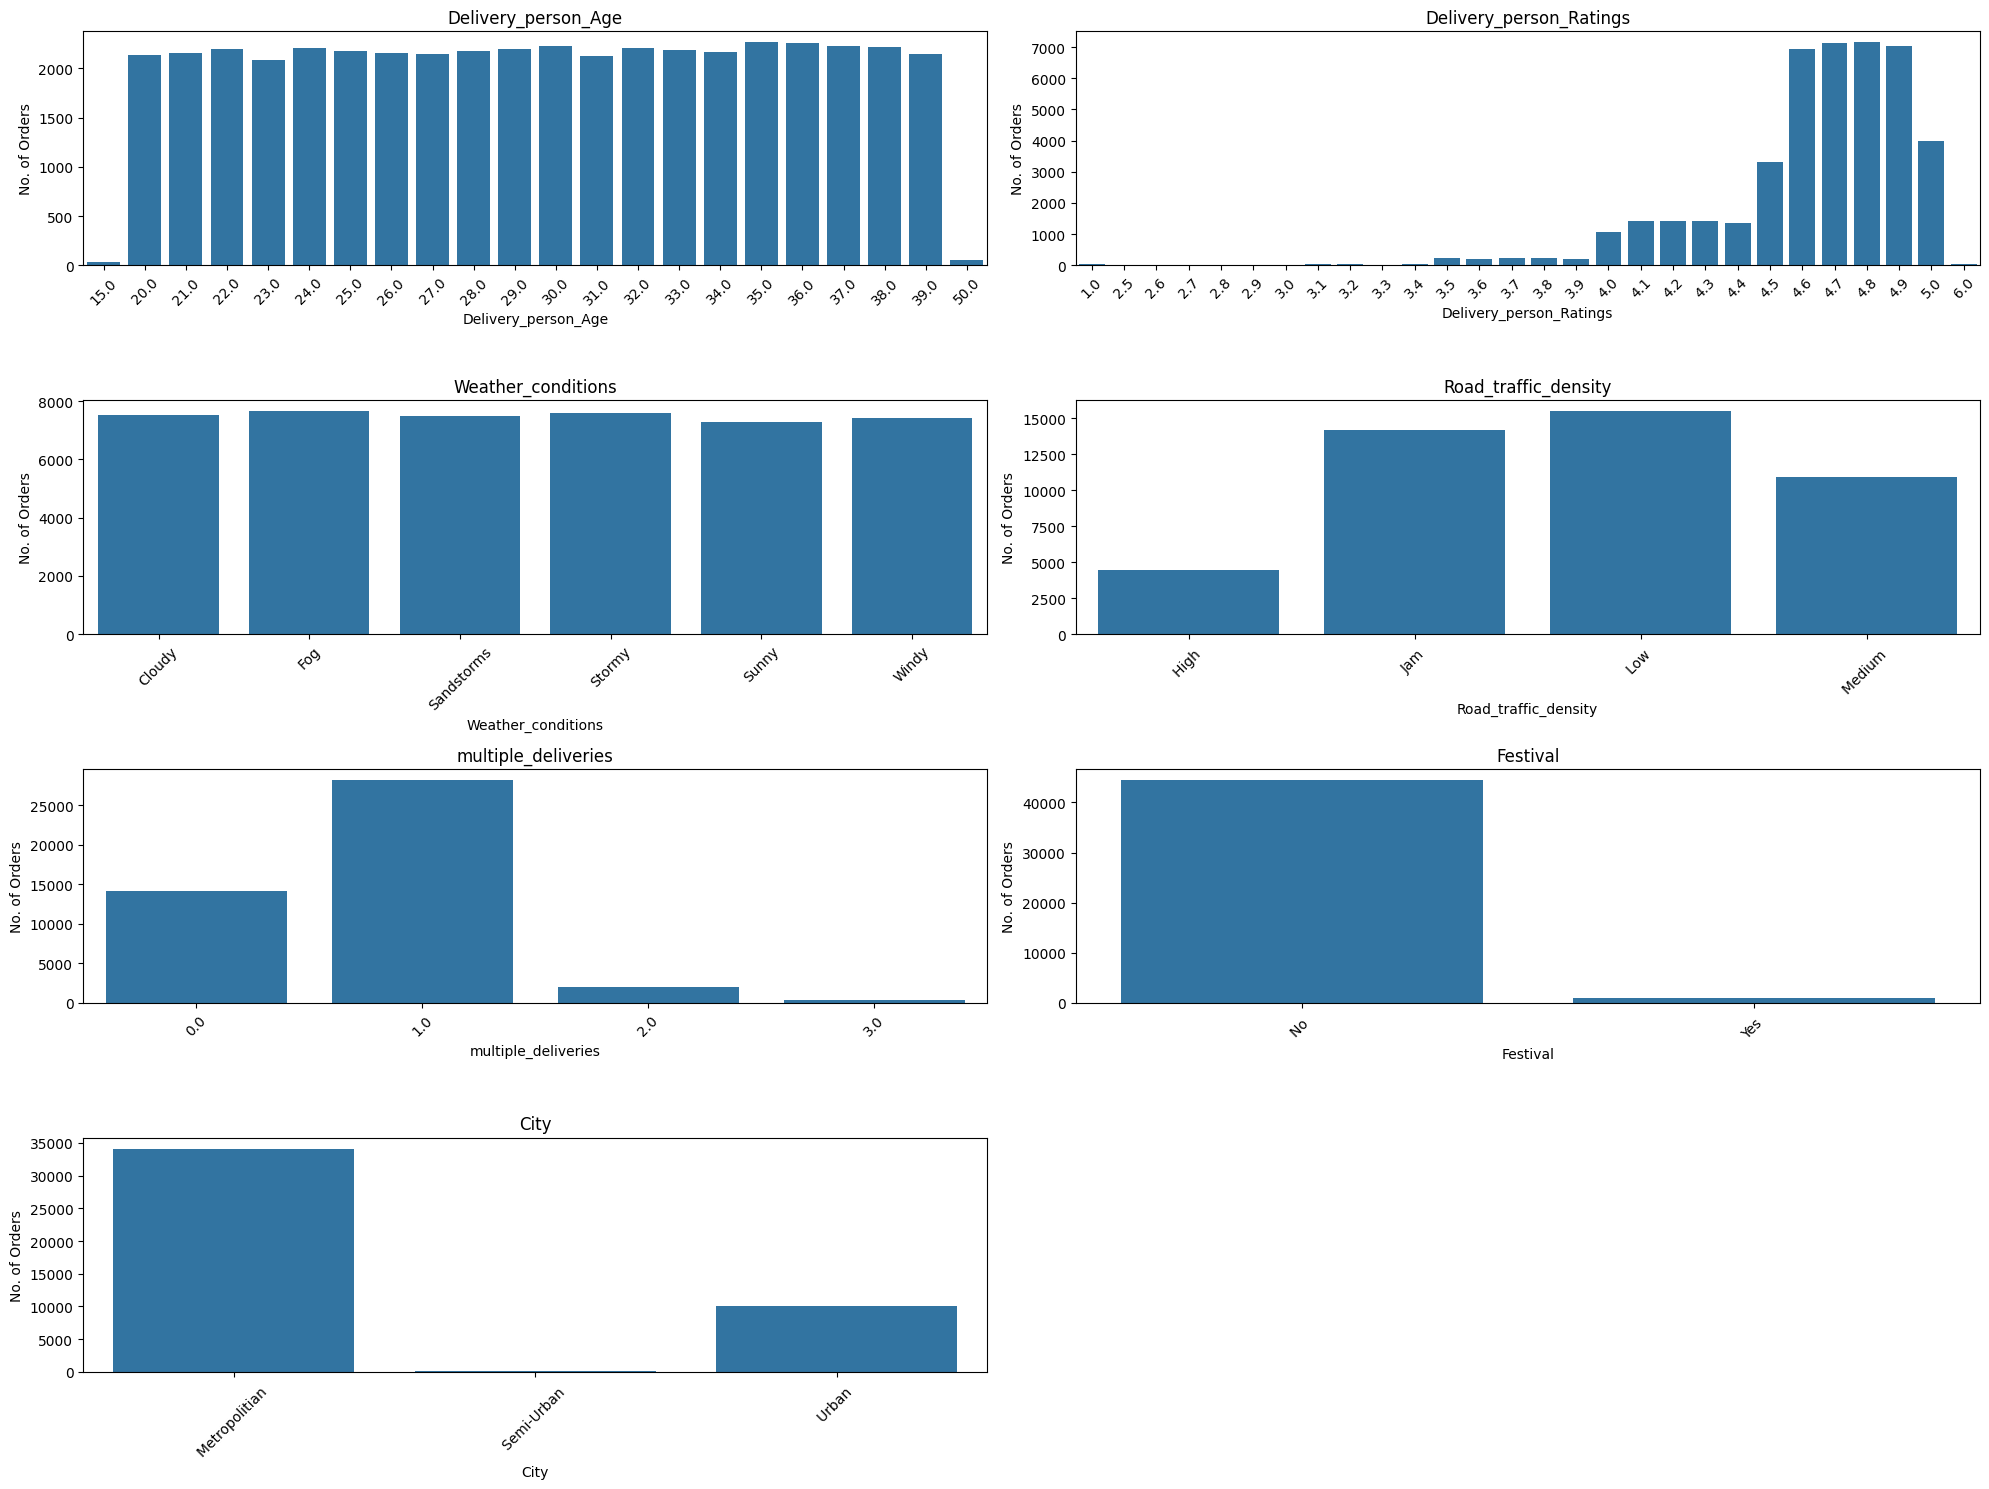

In [11]:
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weather_conditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df_train, x=column_name, order=df_train[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)

if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

## Handling null values

In [12]:
def handle_null_values(df):
    df_train['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df_train['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df_train['City'].fillna(df['City'].mode()[0], inplace=True)
    df_train['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df_train['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df_train['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df_train['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)

handle_null_values(df_train)
df_train.isnull().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

## Feature Engineering

In [13]:
def extract_date_features(data):
    data["Date"] = data.Order_Date.dt.day

extract_date_features(df_train)

df_train['Date'] = df_train['Date'].astype('float64')

## Calculating Time

In [14]:
import pandas as pd
import numpy as np

def calculate_time_diff(df):
    # Convert columns to datetime
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])

    # Handle missing values in Time_Orderd and Time_Order_picked
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'], errors='coerce')
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'], errors='coerce')

    # Calculate prepare time directly by subtracting timestamps
    df['Time_Order_picked_formatted'] = df['Order_Date'] + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']

    # Calculate prepare time in minutes
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60

    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)

    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)

# Call the function with the dataframe
calculate_time_diff(df_train)
df_train['order_prepare_time'] = df_train['order_prepare_time'].astype('float64')

## Calculating Distance

In [15]:
#Calculate distance between restaurant location & delivery location
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")
        
    # Drop all the time & date related columns
    df.drop(['Restaurant_latitude','Restaurant_longitude', 'Delivery_location_latitude','Delivery_location_longitude'], axis=1, inplace=True)

calculate_distance(df_train)
df_train['distance'] = df_train['distance'].astype('float64')

## Data Preprocessing

### 1.Categorical Feature Encoding

In [16]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(df):
    # Specify the columns you want to print the label encoding for
    columns_to_print = ['Weather_conditions', 'Type_of_vehicle', 'Festival', 'City', 'Road_traffic_density']
    
    # Create a LabelEncoder instance
    label_encoder = LabelEncoder()
    
    # Iterate over the specified columns
    for col in columns_to_print:
        if col in df.columns:
            # Fit and transform the column
            df[col] = label_encoder.fit_transform(df[col])
            
            # Print the original categories and their assigned values
            print(f"\nLabel encoding for '{col}':")
            for index, label in enumerate(label_encoder.classes_):
                print(f"{label}: {index}")

# Example usage with df_train
label_encoding(df_train)


Label encoding for 'Weather_conditions':
Cloudy: 0
Fog: 1
Sandstorms: 2
Stormy: 3
Sunny: 4
Windy: 5

Label encoding for 'Type_of_vehicle':
bicycle : 0
electric_scooter : 1
motorcycle : 2
scooter : 3

Label encoding for 'Festival':
No : 0
Yes : 1

Label encoding for 'City':
Metropolitian : 0
Semi-Urban : 1
Urban : 2

Label encoding for 'Road_traffic_density':
High : 0
Jam : 1
Low : 2
Medium : 3


In [17]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(df_train)   

### 2.Correlation Analysis

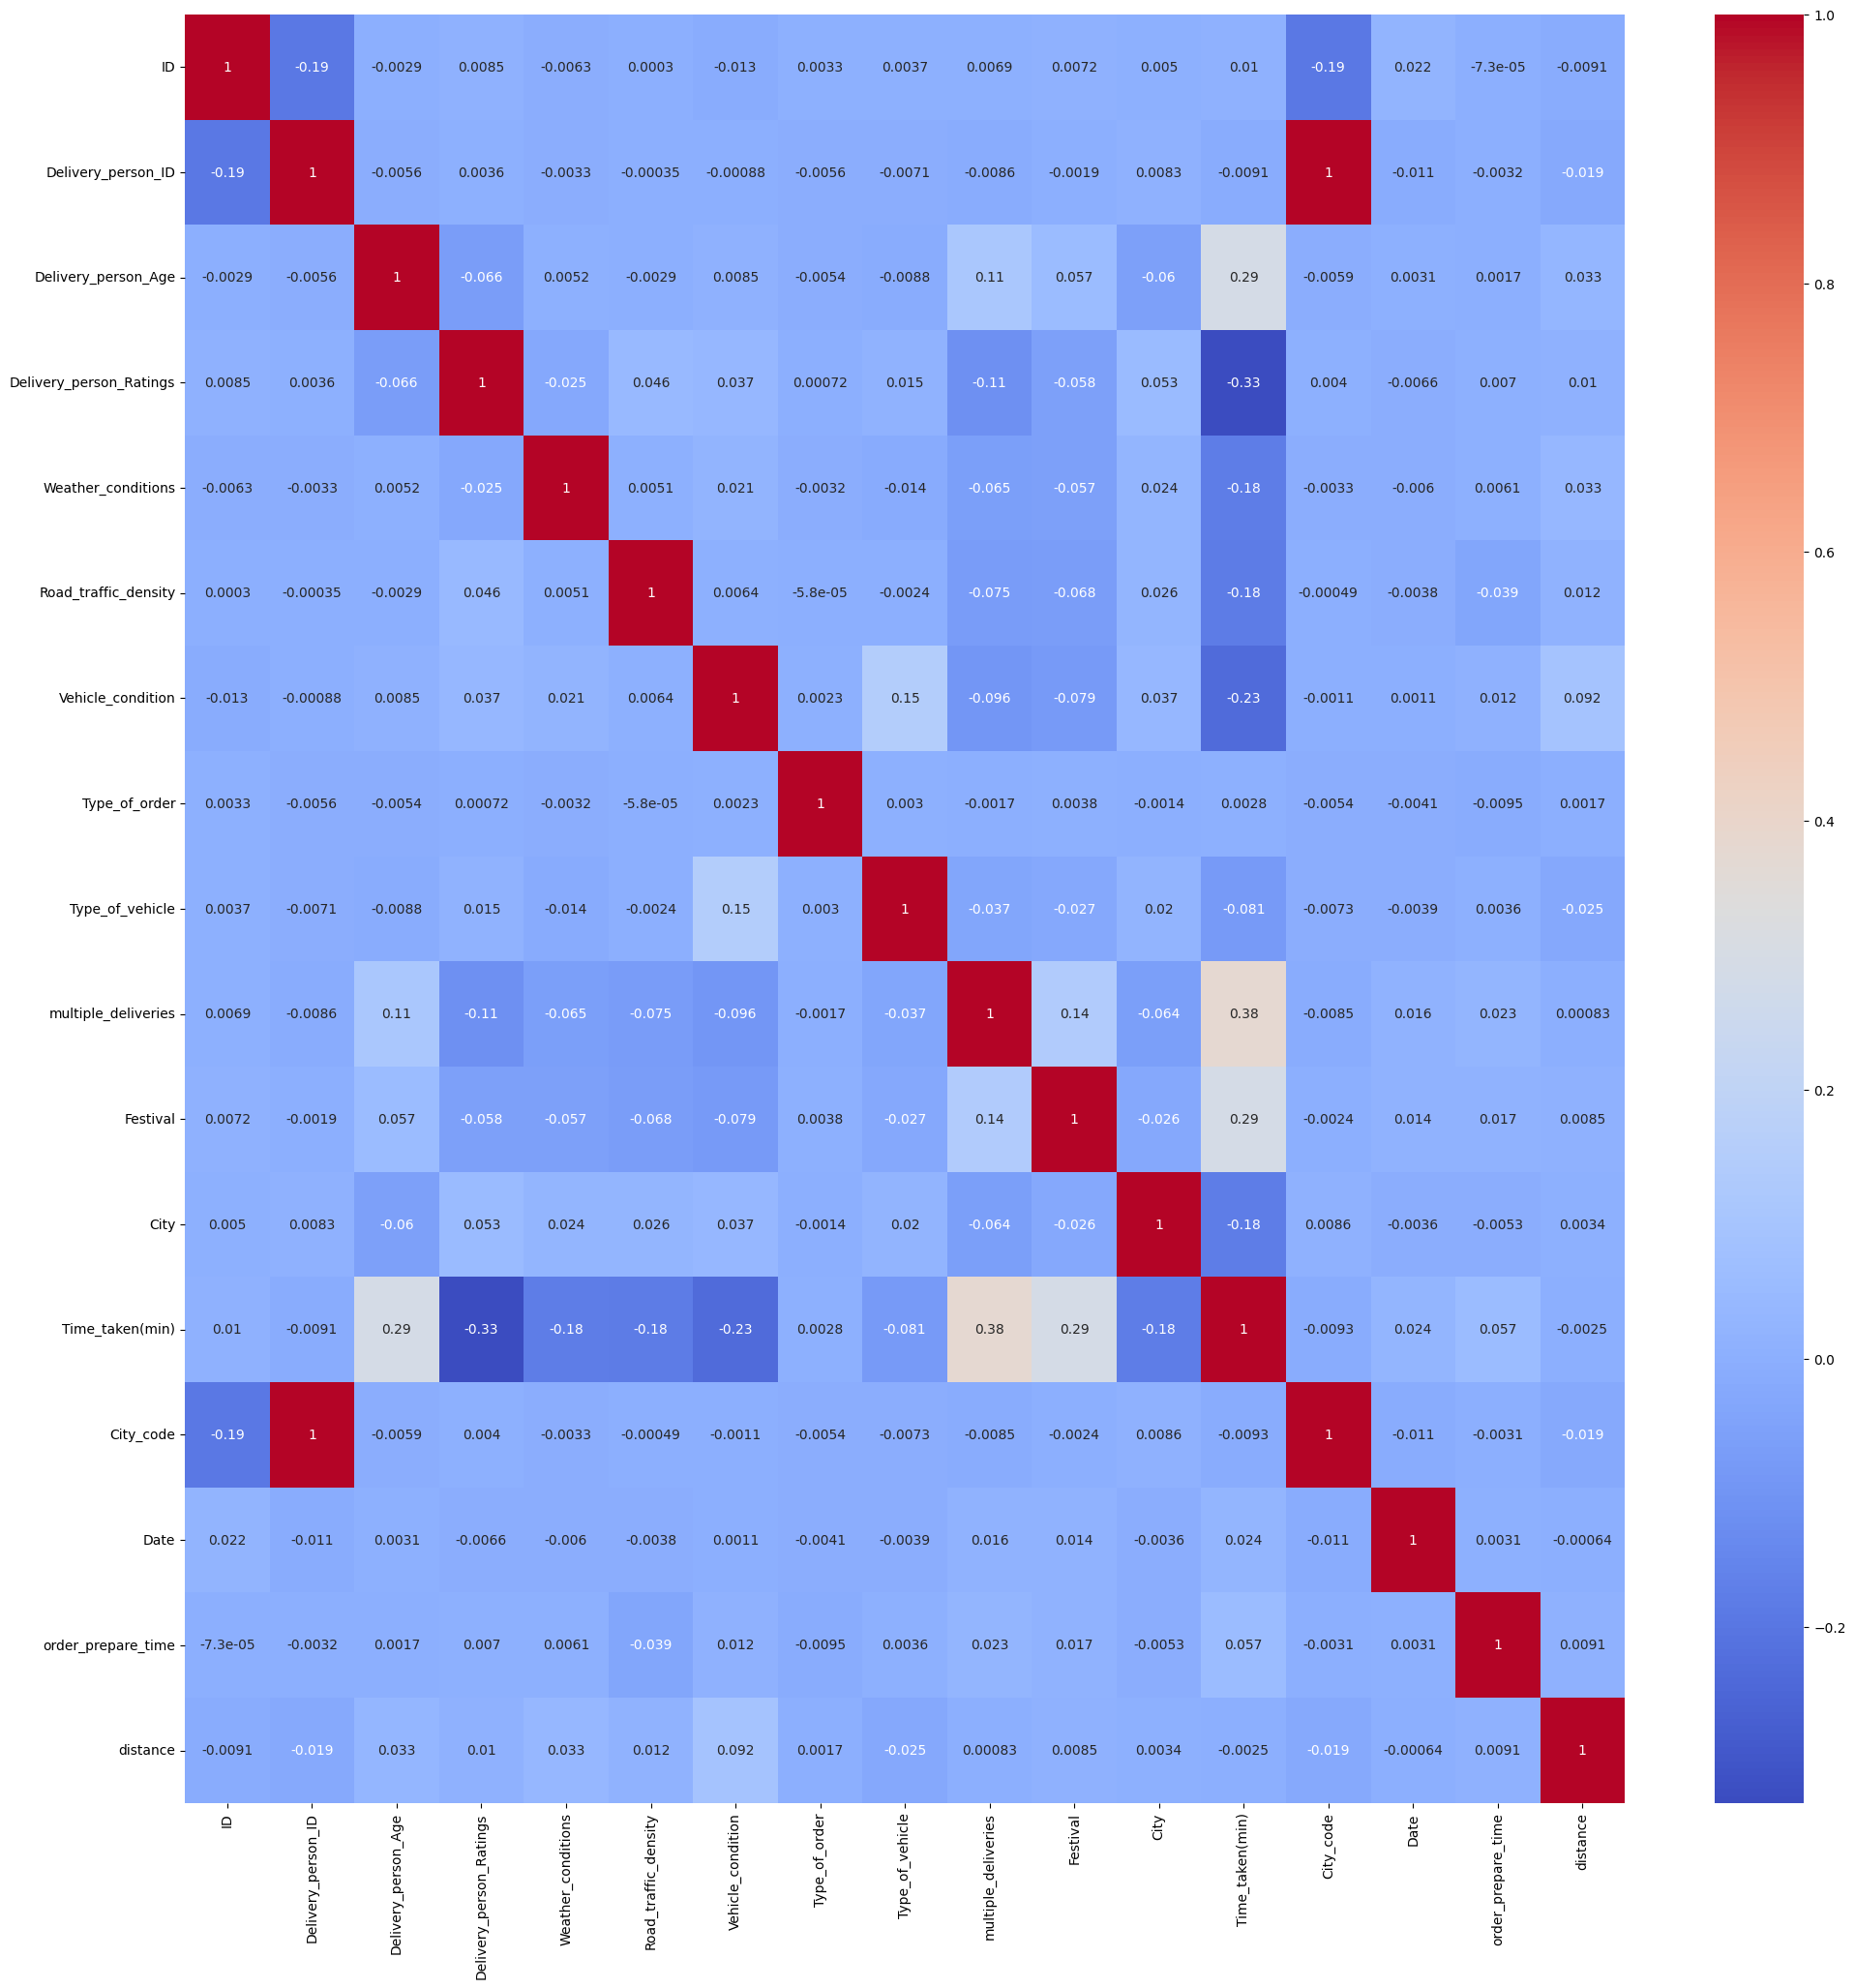

Time_taken(min)            1.000000
multiple_deliveries        0.378276
Delivery_person_Age        0.292663
Festival                   0.290046
order_prepare_time         0.056775
Date                       0.023989
ID                         0.010032
Type_of_order              0.002847
distance                  -0.002526
Delivery_person_ID        -0.009113
City_code                 -0.009268
Type_of_vehicle           -0.080572
City                      -0.177778
Weather_conditions        -0.179866
Road_traffic_density      -0.183015
Vehicle_condition         -0.234398
Delivery_person_Ratings   -0.330729
Name: Time_taken(min), dtype: float64


In [18]:
# Correlation matrix
corr_matrix = df_train.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Correlation of independent features with the target
print(corr_matrix['Time_taken(min)'].sort_values(ascending=False))

### 3.ANOVA for Categorical Features

In [19]:
from scipy import stats

categorical_features = ['City', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City_code', 'Weather_conditions','Vehicle_condition']
for feature in categorical_features:
    f_val, p_val = stats.f_oneway(*[df_train[df_train[feature] == cat]['Time_taken(min)'] for cat in df_train[feature].unique()])
    print(f'ANOVA for {feature}: F-value = {f_val}, P-value = {p_val}')

ANOVA for City: F-value = 1360.9767671874488, P-value = 0.0
ANOVA for Type_of_order: F-value = 1.169880055124585, P-value = 0.3195264597450762
ANOVA for Type_of_vehicle: F-value = 421.6862386707681, P-value = 3.0600471488274287e-270
ANOVA for Festival: F-value = 4187.72890573519, P-value = 0.0
ANOVA for City_code: F-value = 1.2984281793738928, P-value = 0.16226818955122868
ANOVA for Weather_conditions: F-value = 575.4493464898069, P-value = 0.0
ANOVA for Vehicle_condition: F-value = 1323.3228300150674, P-value = 0.0


### 4.Split Training & Testing Data Based On Correlation Analysis and ANOVA

In [20]:
# List of selected features for X
selected_features = [
    'multiple_deliveries',
    'Delivery_person_Age',
    'Festival',
    'order_prepare_time',
    'Weather_conditions',
    'Type_of_vehicle',
    'Road_traffic_density',
    'Vehicle_condition',
    'Delivery_person_Ratings',
    'City', 
    'Date'
]

# Independent features (X) and target feature (Y)
X = df_train[selected_features]
Y = df_train['Time_taken(min)']


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### 5.Standardisation

In [21]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Perform standardization on the training data
X_train = scaler.transform(X_train)

# Perform standardization on the testing data
X_test = scaler.transform(X_test)

## Model Building

In [22]:
import xgboost as xgb

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

param_grid = [
    {},
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()

# Create a XGB regressor model
model = xgb.XGBRegressor(n_estimators=20, max_depth=9)

# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression:
Best parameters: {}
Best R2 score: 0.421386997220087

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.6444151685568331

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.7505390085123779

XGBRegressor:
Best parameters: {'max_depth': 9, 'n_estimators': 30}
Best R2 score: 0.7933196210734351



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluating Model

In [23]:
# Make predictions on the test data
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))

Mean Absolute Error (MAE): 3.38
Mean Squared Error (MSE): 18.24
Root Mean Squared Error (RMSE): 4.27
R-squared (R2) Score: 0.79


## Hyperparameter Tuning using GridSearchCV For XGBoost

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor()

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Use the best model for predictions
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R-squared:", round(r2, 2))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.9s
[CV] END colsampl

## Saving Best Model for Deployment


In [25]:
import pickle

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Save the best model to a pickle file
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved as 'best_xgb_model.pkl'")

Best model saved as 'best_xgb_model.pkl'
